In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import asyncio
import os
from dataclasses import dataclass, field
from typing import Literal, Any

import pandas as pd
from dotenv import load_dotenv
from dspy import LM, ChainOfThought, InputField, OutputField, Signature, configure
from fastembed import TextEmbedding
from langchain.schema import Document
from langchain.tools.retriever import create_retriever_tool
from langchain_community.document_loaders import CSVLoader
from langchain_community.vectorstores import FAISS
from langchain_core.embeddings import Embeddings
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_deepseek import ChatDeepSeek
from langchain_tavily import TavilySearch
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langsmith import traceable
from loguru import logger
from pydantic import BaseModel, Field
from IPython.display import Markdown, display

In [3]:
_ = load_dotenv()
llm = ChatDeepSeek(model="deepseek-chat")
df = pd.read_csv("data/generative_ai_medical_imaging_2019-2025.csv")
df["Title_Abstract"] = df["Title"] + ".\n " + df["Abstract"].fillna("")
df.drop(columns=["Title", "Abstract"], inplace=True)
df.to_csv("data/tests.csv", index=False)

In [4]:
embeddings = TextEmbedding(
    model_name="jinaai/jina-embeddings-v2-base-de",
    cache_dir=os.path.expanduser("~/.cache/fastembed"),
)

splitter = RecursiveCharacterTextSplitter(
    chunk_size=800,
    chunk_overlap=100,
)

loader = CSVLoader(
    file_path="data/tests.csv",
    source_column="Pmid",
    content_columns=["Title_Abstract"],
    metadata_columns=[
        "Pmid",
        "Url",
        "Authors",
        "Keywords",
        "Journal",
        "Affiliations",
        "Publication Date",
        "References",
    ],
)

documents = loader.load()
splitted_documents = splitter.split_documents(documents)

In [5]:
splitted_documents[1].page_content

'<b>Background/Objectives</b>: The integration of artificial intelligence (AI) in medical imaging is rapidly advancing, yet its application in gynecologic use remains limited. This proof-of-concept study presents the development and validation of a convolutional neural network (CNN) designed to automatically detect and classify endometrial polyps. <b>Methods</b>: A multicenter dataset (n = 3) comprising 65 hysteroscopies was used, yielding 33,239 frames and 37,512 annotated objects. Still frames were extracted from full-length videos and annotated for the presence of histologically confirmed polyps. A YOLOv1-based object detection model was used with a 70-20-10 split for training, validation, and testing. Primary performance metrics included recall, precision, and mean average precision'

In [6]:
def batch_process(
    documents: list[Document],
    embeddings,
    persist_directory,
    batch_size=10,
):
    # Check if the persist directory exists
    if not os.path.exists(persist_directory):
        logger.warning(
            f"Persist directory {persist_directory} does not exist. Creating it"
        )
        os.makedirs(persist_directory, exist_ok=True)

    # Create the batches
    batch_docs = [
        documents[i : i + batch_size] for i in range(0, len(documents), batch_size)
    ]

    if os.path.exists(os.path.join(persist_directory, "index.faiss")):
        logger.info(
            f"Vector Index already exists. Loading it from {persist_directory}."
        )
        vector_index = FAISS.load_local(
            persist_directory,
            embeddings=embeddings,
            allow_dangerous_deserialization=True,
        )
    else:
        logger.info("Creating new FAISS index from documents")
        # Create the vector_store
        vector_index = FAISS.from_documents(batch_docs[0], embeddings)

        for batch in batch_docs[1:]:
            vector_index.add_documents(batch)

        # Persist the index
        vector_index.save_local(persist_directory)

    return vector_index

In [7]:
@dataclass
class FastEmbed(Embeddings):
    fe: TextEmbedding = field(default_factory=TextEmbedding)

    def embed_documents(self, documents: list[str]) -> list[list[float]]:
        return [emb.tolist() for emb in self.fe.embed(documents)]

    def embed_query(self, query: str) -> list[float]:
        return list(self.fe.embed([query]))[0].tolist()


embedding_model = FastEmbed(
    TextEmbedding(
        model_name="jinaai/jina-embeddings-v2-base-de",
        cache_dir=os.path.expanduser("~/.cache/fastembed"),
    )
)

In [8]:
vector_store = batch_process(
    splitted_documents, embedding_model, persist_directory="faiss_index"
)

2025-09-03 22:56:56.339 | INFO     | __main__:batch_process:20 - Vector Index already exists. Loading it from faiss_index.


In [9]:
retriever = vector_store.as_retriever(search_kwargs={"k": 10})

# result = retriever.invoke("How has artificial intelligence helped propagate medicine?")

In [10]:
class StructuredOutput(BaseModel):
    answer: list[str] = Field(description="A List of search queries")


dspy_lm = LM(
    "deepseek/deepseek-chat",
    api_key=os.getenv("DEEPSEEK_API_KEY"),
    base_url="https://api.deepseek.com",
)
configure(lm=dspy_lm)


class MultiQueryGenerator(Signature):
    """Generate multiple research queries from a single user query."""

    question = InputField(desc="Original user query")
    num_queries = InputField(desc="Number of research queries to generate")
    research_queries: StructuredOutput = OutputField(
        desc="Generate a list of search terms to for the questions to aid in web search for an AI agent"
    )


query_optimizer = ChainOfThought(MultiQueryGenerator)


@traceable(name="query_generator")
def query_generator(question: str, num_queries: int):
    try:
        return query_optimizer(
            question=question, num_queries=num_queries
        ).research_queries.answer
    except Exception as e:
        print(f"An error occurred during query generation: {e}")
        return []

In [11]:
queries = query_generator(
    "What role can generative AI play in designing novel CAR constructs targeting solid tumors?",
    5,
)

In [12]:
queries

['generative AI design CAR constructs solid tumors',
 'deep learning optimize CAR-T cell therapy for solid cancers',
 'AI-generated novel CAR antigens targeting tumor microenvironment',
 'reinforcement learning in CAR construct engineering for solid malignancies',
 'generative adversarial networks (GANs) for predicting CAR-T efficacy in solid tumors']

In [13]:
async def tavily_search_async(
    search_queries: list[str],
    max_results: int = 5,
    include_raw_content: bool = False,
    topic: Literal["general", "news", "finance"] = "general",
):
    tavily_search = TavilySearch(
        max_results=max_results, include_raw_content=include_raw_content, topic=topic
    )
    tasks = [tavily_search.ainvoke({"query": q}) for q in search_queries]
    results = await asyncio.gather(*tasks)
    return results

In [14]:
retriever_tool = create_retriever_tool(
    retriever,
    "medical_paper_retriever",
    "Retrieves relevant medical research papers and their metadata (e.g., title, abstract, references) to support evidence-based answers.",
)
# tavily_tool = TavilySearch(max_results=2, topic="general")
search_response = await tavily_search_async(
    queries, max_results=5, include_raw_content=True
)

In [17]:
@dataclass
class SourceFormatter:
    max_tokens_per_source: int = 1000
    include_raw_content: bool = True
    chars_per_token: int = 5
    markdown_output: bool = False

    @staticmethod
    def _extract_sources_list(
        search_response: dict[str, Any] | list,
    ) -> list[dict[str, Any]]:
        """Extract sources list from various response formats."""
        if isinstance(search_response, dict):
            return search_response.get("results", [])
        elif isinstance(search_response, list):
            sources_list = []
            for response in search_response:
                if isinstance(response, dict) and "results" in response:
                    sources_list.extend(response["results"])
                elif isinstance(response, dict):
                    sources_list.append(response)
                elif isinstance(response, list):
                    sources_list.extend(response)
            return sources_list
        else:
            raise ValueError(
                "Input must be either a dict with 'results' key or a list of search results"
            )

    @staticmethod
    def _truncate_content(content: str, char_limit: int = 4000) -> str:
        """Truncate content to specified character limit."""
        if not content:
            return "No content available"
        if len(content) <= char_limit:
            return content
        truncate_point = content.rfind(" ", 0, char_limit)
        if (
            truncate_point == -1 or truncate_point < char_limit * 0.8
        ):  # Returns -1 if not found, check if the " " occurs before the 80% of the char_limit
            truncate_point = char_limit
        return content[:truncate_point].rstrip() + "... [content truncated]"

    def _format_single_source(
        self,
        source: dict[str, Any],
        index: int,
        char_limit: int,
    ) -> str:
        """Format a single source for display."""
        title = source.get("title", "Untitled Source")
        url = source.get("url", "No URL available")
        content = source.get("content", "No content summary available")
        raw_content = source.get("raw_content", "")

        if self.markdown_output:
            lines = [
                f"## Source {index}: {title}",
                f"**URL:** {url}",
                f"**Summary:** {content}",
            ]
        else:
            lines = [
                f"Source {index}: {title}",
                f"URL: {url}",
                f"Most relevant content: {content}",
            ]

        if self.include_raw_content:
            if raw_content:
                truncated_content = self._truncate_content(raw_content, char_limit)
                token_estimate = char_limit // 4

                if self.markdown_output:
                    lines.append(
                        f"**Full content** (Limited to ~{token_estimate} tokens):"
                    )
                    lines.append(f"```\n{truncated_content}\n```")
                else:
                    lines.append(
                        f"Full source content (limited to ~{token_estimate} tokens):"
                    )
                    lines.append(truncated_content)
            else:
                warning = "No raw content available for this source"
                lines.append(
                    f"**Note:** {warning}"
                    if self.markdown_output
                    else f"Note: {warning}"
                )

        return "\n\n".join(lines)

    def _format_unique_sources(
        self,
        unique_sources: dict[str, dict[str, Any]],
        max_tokens_per_source: int,
        chars_per_token: int,
    ) -> str:
        """Format unique sources for display."""
        char_limit = chars_per_token * max_tokens_per_source
        formatted_sections = []
        for i, (url, source) in enumerate(unique_sources.items(), 1):
            section = self._format_single_source(source, i, char_limit)
            formatted_sections.append(section)

        header = "# Sources\n\n" if self.markdown_output else "Sources:\n\n"
        separator = "\n---\n\n" if self.markdown_output else "\n" + "=" * 50 + "\n\n"
        return header + separator.join(formatted_sections)

    def deduplicate_and_format_sources(
        self,
        search_response: dict[str, Any] | list,
        return_dict: bool = False,
    ) -> str | dict[str, dict[str, Any]]:
        """Extract, deduplicate by URL, and format sources for display."""
        logger.info("Processing sources for deduplication and formatting")

        unique_sources = {}
        sources_list = self._extract_sources_list(search_response)

        for source in sources_list:
            url = source.get("url")
            if url and url not in unique_sources:
                unique_sources[url] = source

        logger.info(f"Found {len(unique_sources)} unique sources")

        if return_dict:
            return unique_sources

        if not unique_sources:
            return "No unique sources found after deduplication"

        formatted_output = self._format_unique_sources(
            unique_sources,
            self.max_tokens_per_source,
            self.chars_per_token,
        )
        
        if self.markdown_output:
            return display(Markdown(formatted_output))
        
        return formatted_output

In [18]:
formatter = SourceFormatter(markdown_output=True)
print(formatter.deduplicate_and_format_sources(search_response))

2025-09-03 22:57:27.345 | INFO     | __main__:deduplicate_and_format_sources:117 - Processing sources for deduplication and formatting
2025-09-03 22:57:27.360 | INFO     | __main__:deduplicate_and_format_sources:127 - Found 23 unique sources


# Sources

## Source 1: AI-informed approach to CAR design enhances bi-specific CAR T cells

**URL:** https://www.stjude.org/media-resources/news-releases/2025-medicine-science-news/ai-informed-approach-to-car-design-enhances-bi-specific-car-t-cells.html

**Summary:** A computational approach by St. Jude Children’s Research Hospital scientists promises to make designing T cell-based immunotherapies that target two cancer-related antigens at the same time far easier and faster. “We have developed and validated a computational tool that can significantly accelerate the design of tandem CAR constructs with improved surface expression and anti-tumor function,” said co-corresponding author Giedre Krenciute, PhD, St. Jude Department of Bone Marrow Transplantation & Cellular Therapy. “Our most compelling result is that we completely cleared tumors in four out of five mice with the CAR T cells that had the computationally optimized tandem construct,” said co-first author Michaela Meehl, St. Jude Department of Bone Marrow Transplantation & Cellular Therapy.

**Full content** (Limited to ~1250 tokens):

```
# AI-informed approach to CAR design enhances bi-specific CAR T cells

Scientists at St. Jude Children’s Research Hospital have developed and validated an approach to design better immunotherapies that target two cancer-related proteins at once.

Memphis, Tennessee, August 13, 2025

![Group of four scientists working at a table ](/content/sites/www/en_US/home/media-resources/news-releases/2025-medicine-science-news/ai-informed-approach-to-car-design-enhances-bi-specific-car-t-cells/jcr:content/par-1/cnt_row_387680187/par-1/cnt_column/par-1/cnt_image.img.16.medium.jpg/1755026878153.jpg)

(L to R) Co-corresponding author M. Madan Babu, PhD, FRS, St. Jude Senior Vice President of Data Science, Chief Data Scientist, Center of Excellence for Data-Driven Discovery director, and Department of Structural Biology member, co-first authors Kalyan Immadisetty and Michaela Meehl, St. Jude Department of Bone Marrow Transplantation & Cellular Therapy, co-corresponding author Giedre Krenciute, PhD, all of the St. Jude Department of Bone Marrow Transplantation & Cellular Therapy.

A computational approach by St. Jude Children’s Research Hospital scientists promises to make designing T cell-based immunotherapies that target two cancer-related antigens at the same time far easier and faster. Chimeric antigen receptor (CAR) T cells are a type of immunotherapy that reprograms a patient’s immune cells to target a tumor-specific protein antigen. Targeting just one cell surface antigen often is not enough to eradicate the tumor. Thus, scientists have tried to create CARs that target two proteins at once. However, they have encountered problems, including poor CAR expression on the surface of T cells and suboptimal cancer-killing ability. To address this, St. Jude researchers developed a computational method to screen many theoretical tandem CAR designs and ranked the top candidates for further optimization and validation. The researchers experimentally generated and validated the top-ranked tandem CAR candidates against their chosen targets, demonstrating that the computationally optimized CARs overcame the prior challenges and function better in treating animal models of cancer. The findings were published today in *Molecular Therapy*.

“We have developed and validated a computational tool that can significantly accelerate the design of tandem CAR constructs with improved surface expression and anti-tumor function,” said co-corresponding author [Giedre Krenciute](https://www.stjude.org/research/labs/krenciute-lab.html), PhD, St. Jude [Department of Bone Marrow Transplantation & Cellular Therapy](https://www.stjude.org/research/departments/bone-marrow-transplantation-cellular-therapy.html).

While CAR T cells have successfully treated some blood cancers, they have not been as effective in treating solid and brain tumors. One reason is that cancer cells do not uniformly express the same proteins, so CAR T cells targeting a single antigen can miss malignant cells that do not express that protein, leaving them to regrow the tumor and cause a difficult-to-treat relapse. A tandem bi-specific CAR that targets two cancer-related proteins may prevent the original tumor from escaping the treatment, though optimizing their design has been a time-consuming, labor-intensive and expensive challenge in the field.

“Systematic experimental dissection allowed us to first pinpoint the region within the tandem CAR that was problematic for expression and function,” said co-corresponding author [M. Madan Babu](https://stjude.org/research/labs/babu-lab.html), PhD, FRS, St. Jude Senior Vice President of Data Science, Chief Data Scientist, [Center of Excellence for Data-Driven Discovery](https://www.stjude.org/research/departments/structural-biology/center-of-excellence-data-driven-discovery.html) director, and [Department of Structural Biology](https://www.stjude.org/research/departments/structural-biology.html) member. “This was important and helped guide our efforts as we developed a computational approach for CARs that cleared tumors in our in vivo models more effectively than any single-targeted CAR we tested.”

## Clearing tumors with computationally optimized tandem CARs

The computational pipeline predicted a better design for a tandem CAR that targeted the pediatric-brain tumor-related proteins B7-H3 and IL-13Rα2. The original unoptimized version of the bi-specific tandem CAR failed to reach the surface of the T cell, preventing it from contacting its target protein on tumor cells to perform its cancer-killing function. After confirming that the computationally optimized CAR expressed on the T cell surface, the researchers tested it against several single-targeted CARs in mice with tumors that had a mix of cells with both targets, one target or the other, or neither target, mimicking heterogeneous tumors observed in the clinic.

“Our most compelling result is that we completely cleared tumors in four out of five mice with the CAR T cells that... [content truncated]
```
---

## Source 2: Artificial intelligence for chimeric antigen receptor-based therapies

**URL:** https://pmc.ncbi.nlm.nih.gov/articles/PMC11650588/

**Summary:** This paper examines some of the recent advances of AI for CAR-based therapies, for example, using deep learning (DL) to design CARs that target

**Full content** (Limited to ~1250 tokens):

```
Artificial intelligence for chimeric antigen receptor-based therapies: a comprehensive review of current applications and future perspectives - PMC 

===============
[Skip to main content](https://pmc.ncbi.nlm.nih.gov/articles/PMC11650588/#main-content)

![Image 1](https://pmc.ncbi.nlm.nih.gov/static/img/us_flag.svg)

An official website of the United States government

Here's how you know

Here's how you know

![Image 2](https://pmc.ncbi.nlm.nih.gov/static/img/icon-dot-gov.svg)

**Official websites use .gov**

 A **.gov** website belongs to an official government organization in the United States.

![Image 3](https://pmc.ncbi.nlm.nih.gov/static/img/icon-https.svg)

**Secure .gov websites use HTTPS**

 A **lock** ( ) or **https://** means you've safely connected to the .gov website. Share sensitive information only on official, secure websites.

### PMC Search Update

PMC Beta search will replace the current PMC search the week of September 7, 2025. Try out [PMC Beta search](https://pmc.ncbi.nlm.nih.gov/search/) now and give us your feedback. [Learn more](https://ncbiinsights.ncbi.nlm.nih.gov/2025/08/19/new-pmc-search/)

[![Image 4: NCBI home page](https://pmc.ncbi.nlm.nih.gov/static/img/ncbi-logos/nih-nlm-ncbi--white.svg)](https://www.ncbi.nlm.nih.gov/)

 Search 

Log in
*   [Dashboard](https://www.ncbi.nlm.nih.gov/myncbi/)
*   [Publications](https://www.ncbi.nlm.nih.gov/myncbi/collections/bibliography/)
*   [Account settings](https://www.ncbi.nlm.nih.gov/account/settings/)
*    Log out 

 Search…   Search NCBI 

Primary site navigation

![Image 5: Close](https://pmc.ncbi.nlm.nih.gov/static/img/usa-icons/close.svg) Search  ![Image 6: Search](blob:http://localhost/d03881a649d411fb287ca34fa7ea6fc4)

Logged in as:

*   [Dashboard](https://www.ncbi.nlm.nih.gov/myncbi/)
*   [Publications](https://www.ncbi.nlm.nih.gov/myncbi/collections/bibliography/)
*   [Account settings](https://www.ncbi.nlm.nih.gov/account/settings/)

Log in

[](https://pmc.ncbi.nlm.nih.gov/ "Home")

Search PMC Full-Text Archive 

Search in PMC![Image 7: Search](https://pmc.ncbi.nlm.nih.gov/static/img/usa-icons-bg/search--white.svg)

*   [Journal List](https://pmc.ncbi.nlm.nih.gov/journals/)
*   [User Guide](https://pmc.ncbi.nlm.nih.gov/about/userguide/)

New Try this search in PMC Beta Search

*   [](https://doi.org/10.1177/25151355241305856)View on publisher site
*   [](https://pmc.ncbi.nlm.nih.gov/articles/PMC11650588/pdf/10.1177_25151355241305856.pdf)Download PDF
*   Add to Collections
*   Cite
*   Permalink PERMALINK
---------

Copy   

 As a library, NLM provides access to scientific literature. Inclusion in an NLM database does not imply endorsement of, or agreement with, the contents by NLM or the National Institutes of Health.

 Learn more: [PMC Disclaimer](https://pmc.ncbi.nlm.nih.gov/about/disclaimer/) | [PMC Copyright Notice](https://pmc.ncbi.nlm.nih.gov/about/copyright/)

![Image 8: Therapeutic Advances in Vaccines and Immunotherapy logo](https://cdn.ncbi.nlm.nih.gov/pmc/banners/logo-tavi.png)

Ther Adv Vaccines Immunother

. 2024 Dec 16;12:25151355241305856. doi: [10.1177/25151355241305856](https://doi.org/10.1177/25151355241305856)

*   [Search in PMC](https://www.ncbi.nlm.nih.gov/pmc/?term=%22Ther%20Adv%20Vaccines%20Immunother%22%5Bjour%5D)
*   [Search in PubMed](https://pubmed.ncbi.nlm.nih.gov/?term=%22Ther%20Adv%20Vaccines%20Immunother%22%5Bjour%5D)
*   [View in NLM Catalog](https://www.ncbi.nlm.nih.gov/nlmcatalog?term=%22Ther%20Adv%20Vaccines%20Immunother%22%5BTitle%20Abbreviation%5D)
*   [Add to search](https://pmc.ncbi.nlm.nih.gov/articles/PMC11650588/?term=%22Ther%20Adv%20Vaccines%20Immunother%22%5Bjour%5D)

Artificial intelligence for chimeric antigen receptor-based therapies: a comprehensive review of current applications and future perspectives
=============================================================================================================================================

[Muqadas Shahzadi](https://pubmed.ncbi.nlm.nih.gov/?term=%22Shahzadi%20M%22%5BAuthor%5D)

### Muqadas Shahzadi

1 Department of Zoology, Faculty of Life Sciences, University of Okara, Okara, Pakistan

Writing – original draft, Writing – review & editing

Find articles by [Muqadas Shahzadi](https://pubmed.ncbi.nlm.nih.gov/?term=%22Shahzadi%20M%22%5BAuthor%5D)

1, [Hamad Rafique](https://pubmed.ncbi.nlm.nih.gov/?term=%22Rafique%20H%22%5BAuthor%5D)

### Hamad Rafique

2 College of Food Engineering and Nutritional Science, Shaanxi Normal University, Xi’an, Shaanxi, China

Writing – original draft

Find articles by [Hamad Rafique](https://pubmed.ncbi.nlm.nih.gov/?term=%22Rafique%20H%22%5BAuthor%5D)

2, [Ahmad Waheed](https://pubmed.ncbi.nlm.nih.gov/?term=%22Waheed%20A%22%5BAuthor%5D)

### Ahmad Waheed

3 Department of Zoology, Faculty of Life Sciences, University of Okara, 2 KM Lahore Road, Renala Khurd, Okara 56130, Punjab, Pakistan

Conceptualization, Writing – original draft, Writing – review & editing

Find articles by [Ahmad... [content truncated]
```
---

## Source 3: AI-informed approach to CAR design enhances bi-specific CAR T cells

**URL:** https://ecancer.org/en/news/26909-ai-informed-approach-to-car-design-enhances-bi-specific-car-t-cells

**Summary:** While CAR T cells have successfully treated some blood cancers, they have not been as effective in treating solid and brain tumours. One reason

**Note:** No raw content available for this source
---

## Source 4: From spheroids to organoids: next-generation models for CAR-T cell ...

**URL:** https://pmc.ncbi.nlm.nih.gov/articles/PMC12289599/

**Summary:** This review explores the potential of three-dimensional (3D) culture models, including spheroids and organoids, as tools for studying CAR-T cells in the context

**Full content** (Limited to ~1250 tokens):

```
From spheroids to organoids: next-generation models for CAR-T cell therapy research in solid tumors - PMC 

===============
[Skip to main content](https://pmc.ncbi.nlm.nih.gov/articles/PMC12289599/#main-content)

![Image 1](https://pmc.ncbi.nlm.nih.gov/static/img/us_flag.svg)

An official website of the United States government

Here's how you know

Here's how you know

![Image 2](https://pmc.ncbi.nlm.nih.gov/static/img/icon-dot-gov.svg)

**Official websites use .gov**

 A **.gov** website belongs to an official government organization in the United States.

![Image 3](https://pmc.ncbi.nlm.nih.gov/static/img/icon-https.svg)

**Secure .gov websites use HTTPS**

 A **lock** ( ) or **https://** means you've safely connected to the .gov website. Share sensitive information only on official, secure websites.

### PMC Search Update

PMC Beta search will replace the current PMC search the week of September 7, 2025. Try out [PMC Beta search](https://pmc.ncbi.nlm.nih.gov/search/) now and give us your feedback. [Learn more](https://ncbiinsights.ncbi.nlm.nih.gov/2025/08/19/new-pmc-search/)

[![Image 4: NCBI home page](https://pmc.ncbi.nlm.nih.gov/static/img/ncbi-logos/nih-nlm-ncbi--white.svg)](https://www.ncbi.nlm.nih.gov/)

 Search 

Log in
*   [Dashboard](https://www.ncbi.nlm.nih.gov/myncbi/)
*   [Publications](https://www.ncbi.nlm.nih.gov/myncbi/collections/bibliography/)
*   [Account settings](https://www.ncbi.nlm.nih.gov/account/settings/)
*    Log out 

 Search…   Search NCBI 

Primary site navigation

![Image 5: Close](https://pmc.ncbi.nlm.nih.gov/static/img/usa-icons/close.svg) Search  ![Image 6: Search](blob:http://localhost/d03881a649d411fb287ca34fa7ea6fc4)

Logged in as:

*   [Dashboard](https://www.ncbi.nlm.nih.gov/myncbi/)
*   [Publications](https://www.ncbi.nlm.nih.gov/myncbi/collections/bibliography/)
*   [Account settings](https://www.ncbi.nlm.nih.gov/account/settings/)

Log in

[](https://pmc.ncbi.nlm.nih.gov/ "Home")

Search PMC Full-Text Archive 

Search in PMC![Image 7: Search](https://pmc.ncbi.nlm.nih.gov/static/img/usa-icons-bg/search--white.svg)

*   [Journal List](https://pmc.ncbi.nlm.nih.gov/journals/)
*   [User Guide](https://pmc.ncbi.nlm.nih.gov/about/userguide/)

New Try this search in PMC Beta Search

*   [](https://doi.org/10.3389/fimmu.2025.1626369)View on publisher site
*   [](https://pmc.ncbi.nlm.nih.gov/articles/PMC12289599/pdf/fimmu-16-1626369.pdf)Download PDF
*   Add to Collections
*   Cite
*   Permalink PERMALINK
---------

Copy   

 As a library, NLM provides access to scientific literature. Inclusion in an NLM database does not imply endorsement of, or agreement with, the contents by NLM or the National Institutes of Health.

 Learn more: [PMC Disclaimer](https://pmc.ncbi.nlm.nih.gov/about/disclaimer/) | [PMC Copyright Notice](https://pmc.ncbi.nlm.nih.gov/about/copyright/)

![Image 8: Frontiers in Immunology logo](https://cdn.ncbi.nlm.nih.gov/pmc/banners/logo-frontimmu.gif)

Front Immunol

. 2025 Jul 11;16:1626369. doi: [10.3389/fimmu.2025.1626369](https://doi.org/10.3389/fimmu.2025.1626369)

*   [Search in PMC](https://www.ncbi.nlm.nih.gov/pmc/?term=%22Front%20Immunol%22%5Bjour%5D)
*   [Search in PubMed](https://pubmed.ncbi.nlm.nih.gov/?term=%22Front%20Immunol%22%5Bjour%5D)
*   [View in NLM Catalog](https://www.ncbi.nlm.nih.gov/nlmcatalog?term=%22Front%20Immunol%22%5BTitle%20Abbreviation%5D)
*   [Add to search](https://pmc.ncbi.nlm.nih.gov/articles/PMC12289599/?term=%22Front%20Immunol%22%5Bjour%5D)

From spheroids to organoids: next-generation models for CAR-T cell therapy research in solid tumors
===================================================================================================

[Mégane Jassin](https://pubmed.ncbi.nlm.nih.gov/?term=%22Jassin%20M%22%5BAuthor%5D)

### Mégane Jassin

1 Laboratory of Hematology, Interdisciplinary Cluster for Applied Genoproteomics Institute (GIGA) Institute, University of Liege, Liege,Belgium 

Find articles by [Mégane Jassin](https://pubmed.ncbi.nlm.nih.gov/?term=%22Jassin%20M%22%5BAuthor%5D)

1, [Alix Block](https://pubmed.ncbi.nlm.nih.gov/?term=%22Block%20A%22%5BAuthor%5D)

### Alix Block

1 Laboratory of Hematology, Interdisciplinary Cluster for Applied Genoproteomics Institute (GIGA) Institute, University of Liege, Liege,Belgium 

2 Department of Hematology, University Hospital of Liege, Liege,Belgium 

Find articles by [Alix Block](https://pubmed.ncbi.nlm.nih.gov/?term=%22Block%20A%22%5BAuthor%5D)

1,2, [Laury Désiront](https://pubmed.ncbi.nlm.nih.gov/?term=%22D%C3%A9siront%20L%22%5BAuthor%5D)

### Laury Désiront

1 Laboratory of Hematology, Interdisciplinary Cluster for Applied Genoproteomics Institute (GIGA) Institute, University of Liege, Liege,Belgium 

Find articles by [Laury Désiront](https://pubmed.ncbi.nlm.nih.gov/?term=%22D%C3%A9siront%20L%22%5BAuthor%5D)

1, [Louise Vrancken](https://pubmed.ncbi.nlm.nih.gov/?term=%22Vrancken%20L%22%5BAuthor%5D)

### Louise Vrancken

1 Laboratory of Hematology, Interdisciplinary... [content truncated]
```
---

## Source 5: Unleashing the power of CAR-M therapy in solid tumors - Frontiers

**URL:** https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2025.1615760/full

**Summary:** This comprehensive review focuses on the current state and future prospects of CAR macrophage technology, emphasising its applications in solid malignancies.

**Full content** (Limited to ~1250 tokens):

```
Your new experience awaits. Try the new design now and help us make it even better

REVIEW article

Front. Immunol., 11 June 2025

Sec. Cancer Immunity and Immunotherapy

Volume 16 - 2025 | <https://doi.org/10.3389/fimmu.2025.1615760>

This article is part of the Research TopicCellular Immunotherapy: Transforming Cancer Treatment[View all 14 articles](https://www.frontiersin.org/research-topics/66551/cellular-immunotherapy-transforming-cancer-treatment/articles)

# Unleashing the power of CAR-M therapy in solid tumors: a comprehensive review

[Ahsen Morva](https://loop.frontiersin.org/people/2937334/overview)1,2Ana Belén Arroyo3,4\*[Liudmila Andreeva](https://loop.frontiersin.org/people/3062148/overview)5Ana Tapia-Abellán3,6†[Ginés Luengo-Gil](https://loop.frontiersin.org/people/2299798/overview)3,4\*†

* 1Biotechnology Research Group, Climat & Life Sciences, TUBITAK Marmara Research Center, Kocaeli, Türkiye
* 2Transplant Immunology Research Center of Excellence TIREX, Koc University School of Medicine, Istanbul, Türkiye
* 3Pathology Department, Santa Lucía University General Hospital, Murcian Institute of Biosanitary Research (IMIB), Cartagena, Spain
* 4Health Sciences Department, Catholic University of Murcia (UCAM), Guadalupe, Spain
* 5Structural Immuno-Oncology Research Group, Department of Medical Oncology and Pneumology, University Hospital Tübingen, Tübingen, Germany
* 6Immunology Research Group, Department of Biochemistry and Molecular Biology B and Immunology, Faculty of Medicine, University of Murcia, Murcia, Spain

Chimeric antigen receptor (CAR) macrophage therapy represents a promising new frontier in cancer immunotherapy, with the potential to overcome the limitations of CAR-T cell approaches, particularly in solid tumours. This comprehensive review focuses on the current state and future prospects of CAR macrophage technology, emphasising its applications in solid malignancies across preclinical and early clinical development. The key topics covered included CAR design optimisation, macrophage sources and engineering strategies, mechanisms of antitumour activity, *in vivo* efficacy in animal models, initial clinical trial results, and challenges for broader implementation. The unique properties of macrophages, including tumour penetration and microenvironment modulation, offer significant advantages over T cell-based therapies in solid-tumour settings. However, strategies to enhance persistence, maintain proinflammatory phenotypes, and improve manufacturing are required. Although early research suggests additional applications beyond oncology, including for infectious and inflammatory diseases, this review primarily concentrates on the oncologic potential of CAR-M therapies. Continued optimisation and larger randomised trials will be critical to establish clinical efficacy and define the role of this approach in the treatment of solid tumours.

## 1 Introduction

Cellular immunotherapy strategies have gained momentum with the success of chimeric antigen receptor T-cell (CAR-T) therapy for the treatment of blood cancers ([1](#B1), [2](#B2)). However, these promising success stories reveal unavoidable challenges against solid tumours, which act as physical barriers against CAR-T cells ([3](#B3)–[8](#B8)). Although more than 200 clinical trials involving CAR-T cells have been registered to cure solid tumours, scientists have expanded the study sizes to cross tumour microenvironment (TME)-related hurdles and obtain a safe and stable way to combat tumour cells ([9](#B9), [10](#B10)). Limitations such as diminished antitumour efficacy due to the immunosuppressive TME, scarcity of appropriate tumour-associated antigens (TAAs), tumour-specific antigens (TSAs), dense extracellular matrix (ECM) that keeps CAR-T cells out of the tumour, and severe adverse effects have led scientists to renovate the CAR platform ([3](#B3), [11](#B11)). This unmet need has revolutionised CAR technology and has extended it to screen the innate immune compartment to manipulate other immune cells. Macrophages, after natural killer (NKs) cells, are being explored as alternative immune cells to upgrade this strategy ([5](#B5), [12](#B12)–[14](#B14)).

In the mainstream CAR-T cells, the chimeric antigen receptor macrophage (CAR-M) platform is optimised in alignment with those of the CAR-T and CAR-NK platforms ([15](#B15), [16](#B16)). Macrophages, which are sentinels of the body, have emerged as promising options. They are specialised phagocytic cells of the innate immune system, being the first-line defense of the host by constantly removing dead cells and providing clearance of harmful pathogens. In addition to their wide range of functions, including antigen presentation, macrophages have plastic features and a generous biological gift to keep them in view as a live therapeutic candidate. Furthermore, macrophages are particularly active trafficking to the TME, constituting the largest immune cell population found in tumor... [content truncated]
```
---

## Source 6: Optimizing CAR-T cell therapy for solid tumors: current challenges ...

**URL:** https://jhoonline.biomedcentral.com/articles/10.1186/s13045-024-01625-7

**Summary:** Nov 5, 2024·This review explores strategies to optimize CAR-T cell therapies for solid tumors, focusing on enhancing cytotoxicity and overcoming application restrictions.

**Full content** (Limited to ~1250 tokens):

```
[Skip to main content](#main-content)

[Journal of Hematology & Oncology](/)

[Download PDF](//jhoonline.biomedcentral.com/counter/pdf/10.1186/s13045-024-01625-7.pdf)

* Review
* [Open access](https://www.springernature.com/gp/open-science/about/the-fundamentals-of-open-access-and-open-research)
* Published:

# Optimizing CAR-T cell therapy for solid tumors: current challenges and potential strategies

* [Kexin Ai](#auth-Kexin-Ai-Aff1)[1](#Aff1)[na1](#na1),
* [Bowen Liu](#auth-Bowen-Liu-Aff2)[2](#Aff2)[na1](#na1),
* [Xiaomei Chen](#auth-Xiaomei-Chen-Aff2)[2](#Aff2)[na1](#na1),
* [Chuxin Huang](#auth-Chuxin-Huang-Aff1)[1](#Aff1)[na1](#na1),
* [liping Yang](#auth-liping-Yang-Aff1)[1](#Aff1)[na1](#na1),
* [Weiya Zhang](#auth-Weiya-Zhang-Aff3)[3](#Aff3)[na1](#na1),
* [Jianyu Weng](#auth-Jianyu-Weng-Aff2)[2](#Aff2)[na1](#na1),
* [Xin Du](#auth-Xin-Du-Aff2)[2](#Aff2)[na1](#na1),
* [Kongming Wu](#auth-Kongming-Wu-Aff4-Aff5)[4](#Aff4),[5](#Aff5)[na1](#na1) &
* …
* [Peilong Lai](#auth-Peilong-Lai-Aff2)[2](#Aff2)[na1](#na1)

[*Journal of Hematology & Oncology*](/)
**volume 17**, Article number: 105 (2024)
[Cite this article](#citeas)

* 10k Accesses
* 25 Citations
* [Metrics details](/articles/10.1186/s13045-024-01625-7/metrics)

## Abstract

Chimeric antigen receptor (CAR)-T cell therapy demonstrates substantial efficacy in various hematological malignancies. However, its application in solid tumors is still limited. Clinical studies report suboptimal outcomes such as reduced cytotoxicity of CAR-T cells and tumor evasion, underscoring the need to address the challenges of sliding cytotoxicity in CAR-T cells. Despite improvements from fourth and next-generation CAR-T cells, new challenges include systemic toxicity from continuously secreted proteins, low productivity, and elevated costs. Recent research targets genetic modifications to boost killing potential, metabolic interventions to hinder tumor progression, and diverse combination strategies to enhance CAR-T cell therapy. Efforts to reduce the duration and cost of CAR-T cell therapy include developing allogenic and in-vivo approaches, promising significant future advancements. Concurrently, innovative technologies and platforms enhance the potential of CAR-T cell therapy to overcome limitations in treating solid tumors. This review explores strategies to optimize CAR-T cell therapies for solid tumors, focusing on enhancing cytotoxicity and overcoming application restrictions. We summarize recent advances in T cell subset selection, CAR-T structural modifications, infiltration enhancement, genetic and metabolic interventions, production optimization, and the integration of novel technologies, presenting therapeutic approaches that could improve CAR-T cell therapy’s efficacy and applicability in solid tumors.

## Background

Adoptive T cell therapy, including chimeric antigen receptor (CAR) T cells, has achieved significant success in targeted cancer cell eradication [[1](/articles/10.1186/s13045-024-01625-7#ref-CR1 "Chen R, Chen L, Wang C, Zhu H, Gu L, Li Y, et al. CAR-T treatment for cancer: prospects and challenges. Front Oncol. 2023;13:1288383."), [2](/articles/10.1186/s13045-024-01625-7#ref-CR2 "Mazinani M, Rahbarizadeh F. CAR-T cell potency: from structural elements to vector backbone components. Biomark Res. 2022;10(1):70.")]. Although the FDA has approved CAR-T cell therapies for certain hematological malignancies, a significant proportion of patients relapse within one year after infusion [[3](/articles/10.1186/s13045-024-01625-7#ref-CR3 "Liu Z, Lei W, Wang H, Liu X, Fu R. Challenges and strategies associated with CAR-T cell therapy in blood malignancies. Exp Hematol Oncol. 2024;13(1):22.")]. Moreover, their limited efficacy in solid tumors presents ongoing challenges [[4](/articles/10.1186/s13045-024-01625-7#ref-CR4 "Maude SL, Laetsch TW, Buechner J, Rives S, Boyer M, Bittencourt H, et al. Tisagenlecleucel in children and young adults with B-cell lymphoblastic leukemia. N Engl J Med. 2018;378(5):439–48."), [5](/articles/10.1186/s13045-024-01625-7#ref-CR5 "Brudno JN, Kochenderfer JN. Recent advances in CAR T-cell toxicity: mechanisms, manifestations and management. Blood Rev. 2019;34:45–55.")]. Nevertheless, the majority of patients, particularly those with solid tumors, continue to exhibit resistance to CAR-T cell therapy. Several challenges persist in treating solid tumors with CAR-T cells, including insufficient cytotoxicity, poor infiltration, tumor microenvironment suppression, high costs, and safety concerns [[6](/articles/10.1186/s13045-024-01625-7#ref-CR6 "Zeng W, Zhang P. Resistance and recurrence of malignancies after CAR-T cell therapy. Exp Cell Res. 2022;410(2): 112971.")]. Although some CAR-T products are approved for use with chemotherapy or monoclonal antibodies to enhance engraftment [[7](/articles/10.1186/s13045-024-01625-7#ref-CR7 "Qu C, Zhang H, Cao H, Tang L, Mo H, Liu F, et al. Tumor buster—where will the CAR-T cell therapy ‘missile’... [content truncated]
```
---

## Source 7: Full article: Optimising CAR T therapy for the treatment of solid tumors

**URL:** https://www.tandfonline.com/doi/full/10.1080/14737140.2024.2421194

**Summary:** The challenge of target selection is illustrated by the fact that well over one hundred molecules have been investigated as solid tumor-associated CAR T cell targets pre-clinically [Citation 15], of which more than 30 have been advanced to clinical studies [Citation 16]. doi: 10.1016/j.isci.2024.109411 (Open in a new window)PubMed(Open in a new window)Web of Science ®(Open in a new window)Google Scholar  doi: 10.1016/j.ccell.2019.09.006 (Open in a new window)PubMed(Open in a new window)Web of Science ®(Open in a new window)Google Scholar  doi: 10.1016/j.ccell.2024.07.002 (Open in a new window)PubMed(Open in a new window)Web of Science ®(Open in a new window)Google Scholar  doi: 10.1016/j.cell.2024.04.015 (Open in a new window)PubMed(Open in a new window)Web of Science ®(Open in a new window)Google Scholar 

**Full content** (Limited to ~1250 tokens):

```
Full article: Optimising CAR T therapy for the treatment of solid tumors

===============

[Skip to Main Content](https://www.tandfonline.com/doi/full/10.1080/14737140.2024.2421194#top-content-scroll "Skip to Main Content")

[![Image 1: Taylor and Francis Online homepage](https://www.tandfonline.com/pb-assets/Global/TFO-logo-new-1716484961953.svg)](https://www.tandfonline.com/ "Taylor and Francis Online homepage")

*   Journals

Close Journals Menu

Browse all journals

    *   [Browse all journals A-Z](https://www.tandfonline.com/action/showPublications?pubType=journal&ejf=on)
    *   [Open access journals](https://www.tandfonline.com/openaccess/openjournals)
    *   [Open Select (hybrid) journals](https://www.tandfonline.com/openaccess/openselect)

Browse all books

    *   [Explore Taylor & Francis eBooks](https://www.taylorfrancis.com/)

Publish

    *   [Find a journal](https://www.tandfonline.com/action/showPublications?pubType=journal&ejf=on)
    *   [Search calls for papers](https://authorservices.taylorandfrancis.com/call-for-papers/)
    *   [Journal Suggester](https://authorservices.taylorandfrancis.com/publishing-your-research/choosing-a-journal/journal-suggester/)
    *   [Open access publishing](https://www.tandfonline.com/openaccess)
    *   [Find guidance on Author Services](https://authorservices.taylorandfrancis.com/)

Browse by subject

    *   [Area Studies](https://www.tandfonline.com/subjects/area-studies)
    *   [Arts](https://www.tandfonline.com/subjects/arts)
    *   [Behavioral Sciences](https://www.tandfonline.com/subjects/behavioral-sciences)
    *   [Bioscience](https://www.tandfonline.com/subjects/bioscience)
    *   [Built Environment](https://www.tandfonline.com/subjects/built-environment)
    *   [Communication Studies](https://www.tandfonline.com/subjects/communication-studies)
    *   [Computer Science](https://www.tandfonline.com/subjects/computer-science)
    *   [Earth Sciences](https://www.tandfonline.com/subjects/earth-sciences)
    *   [Economics, Finance, Business & Industry](https://www.tandfonline.com/subjects/economics-finance-business-industry)
    *   [Education](https://www.tandfonline.com/subjects/education)
    *   [Engineering & Technology](https://www.tandfonline.com/subjects/engineering-and-technology)
    *   [Environment & Agriculture](https://www.tandfonline.com/subjects/environment-and-agriculture)
    *   [Environment and Sustainability](https://www.tandfonline.com/subjects/environment-and-sustainability)
    *   [Food Science & Technology](https://www.tandfonline.com/subjects/food-science-and-technology)
    *   [Geography](https://www.tandfonline.com/subjects/geography)

    *   [Global Development](https://www.tandfonline.com/subjects/global-development)
    *   [Health and Social Care](https://www.tandfonline.com/subjects/health-and-social-care)
    *   [Humanities](https://www.tandfonline.com/subjects/humanities)
    *   [Information Science](https://www.tandfonline.com/subjects/information-science)
    *   [Language & Literature](https://www.tandfonline.com/subjects/language-and-literature)
    *   [Law](https://www.tandfonline.com/subjects/law)
    *   [Mathematics & Statistics](https://www.tandfonline.com/subjects/mathematics-and-statistics)
    *   [Medicine, Dentistry, Nursing & Allied Health](https://www.tandfonline.com/subjects/medicine-dentistry-nursing-and-allied-health)
    *   [Museum and Heritage Studies](https://www.tandfonline.com/subjects/museum-and-heritage-studies)
    *   [Physical Sciences](https://www.tandfonline.com/subjects/physical-sciences)
    *   [Politics & International Relations](https://www.tandfonline.com/subjects/politics-and-international-relations)
    *   [Social Sciences](https://www.tandfonline.com/subjects/social-sciences)
    *   [Sports and Leisure](https://www.tandfonline.com/subjects/sports-and-leisure)
    *   [Tourism, Hospitality and Events](https://www.tandfonline.com/subjects/tourism-hospitality-and-events)
    *   [Urban Studies](https://www.tandfonline.com/subjects/urban-studies)

*   Search Close Search Menu 
*   Publish

    *   [Why publish with us?](https://www.tandfonline.com/why-publish-with-us)
    *   [Find a journal](https://www.tandfonline.com/action/showPublications?pubType=journal&ejf=on)
    *   [Search calls for papers](https://authorservices.taylorandfrancis.com/call-for-papers/)
    *   [Journal Suggester](https://authorservices.taylorandfrancis.com/publishing-your-research/choosing-a-journal/journal-suggester/)
    *   [Step-by-step guide](https://authorservices.taylorandfrancis.com/publishing-your-research/)
    *   [Open access publishing](https://www.tandfonline.com/openaccess)

We're here to help

Find guidance on [Author Services](https://authorservices.taylorandfrancis.com/)

[Login](https://www.tandfonline.com/action/showLogin?uri=%2Fdoi%2Ffull%2F10.1080%2F14737140.2024.2421194)|[Register](https://www.tandfonline.com/action/registration?redirectUri=%2F)

Log in or... [content truncated]
```
---

## Source 8: RCMNet: A deep learning model assists CAR-T therapy for leukemia

**URL:** https://www.sciencedirect.com/science/article/abs/pii/S0010482522007922

**Summary:** This study evaluates the effectiveness of RCMNet on a big public dataset and translates it to a clinical dataset for diagnostic applications.

**Note:** No raw content available for this source
---

## Source 9: Spatiotemporal dynamics of tumor–CAR T-cell interaction following ...

**URL:** https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1013117

**Summary:** In this work, we develop a simplified spatiotemporal model for CAR T-cell treatment of solid tumors, and use numerical simulations to compare the effect of introducing CAR T cells via intratumoral injection versus intracavitary administration in diverse cancer types. We demonstrate that the model can reproduce tumor and CAR T-cell data from small imaging studies of local administration of CAR T cells in mouse models. To account for spatial variation in cell concentration and provide insight into how the geometry of the delivery of CAR T cells impacts treatment efficacy, we employ a 3-D reaction-diffusion modeling framework for local administration of CAR T cells to treat solid tumors. In this article, we develop a 3-dimensional spatio-temporal model for CAR T-cell therapies applied to dynamic solid tumors.

**Full content** (Limited to ~1250 tokens):

```
Spatiotemporal dynamics of tumor–CAR T-cell interaction following local administration in solid cancers | PLOS Computational Biology

===============

[Skip to main content](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1013117#main-content)

Advertisement

*   [plos.org](https://plos.org/)
*   [Create account](https://community.plos.org/registration/new)
*   [Sign in](https://journals.plos.org/user/secure/login?page=%2Fploscompbiol%2Farticle%3Fid%3D10.1371%2Fjournal.pcbi.1013117)

*       *   Browse
    *   Publish
    *   About

*   [](https://journals.plos.org/ploscompbiol/ "PLOS Computational Biology")
*   Search[advanced search](https://journals.plos.org/ploscompbiol/search)  

*    7 [Save](https://journals.plos.org/ploscompbiol/article/metrics?id=10.1371/journal.pcbi.1013117#savedHeader)
[Total Mendeley and Citeulike bookmarks.](https://journals.plos.org/ploscompbiol/article/metrics?id=10.1371/journal.pcbi.1013117#savedHeader) 
*    0 [Citation](https://journals.plos.org/ploscompbiol/article/metrics?id=10.1371/journal.pcbi.1013117#citedHeader)
[Paper's citation count computed by Dimensions.](https://journals.plos.org/ploscompbiol/article/metrics?id=10.1371/journal.pcbi.1013117#citedHeader) 
*    659 [View](https://journals.plos.org/ploscompbiol/article/metrics?id=10.1371/journal.pcbi.1013117#viewedHeader)
[PLOS views and downloads.](https://journals.plos.org/ploscompbiol/article/metrics?id=10.1371/journal.pcbi.1013117#viewedHeader) 
*    0 [Share](https://journals.plos.org/ploscompbiol/article/metrics?id=10.1371/journal.pcbi.1013117#discussedHeader)
[Sum of Facebook, Twitter, Reddit and Wikipedia activity.](https://journals.plos.org/ploscompbiol/article/metrics?id=10.1371/journal.pcbi.1013117#discussedHeader) 

Open Access

Peer-reviewed

Research Article

Spatiotemporal dynamics of tumor–CAR T-cell interaction following local administration in solid cancers
=======================================================================================================

*   Katherine Owens,Roles Conceptualization, Data curation, Formal analysis, Investigation, Methodology, Project administration, Software, Validation, Visualization, Writing – original draft, Writing – review & editing

Affiliations Department of Applied Mathematics, University of Washington, Seattle, Washington, United States of America, Vaccine and Infectious Disease Division, Fred Hutchinson Cancer Center, Seattle, Washington, United States of America

[![Image 1: ORCID logo](https://journals.plos.org/resource/img/orcid_16x16.png) https://orcid.org/0000-0002-5695-0203](https://orcid.org/0000-0002-5695-0203 "ORCID Registry") ⨯ 
*   Aminur Rahman,Roles Conceptualization, Formal analysis, Methodology, Software, Visualization, Writing – original draft, Writing – review & editing

Affiliations Department of Applied Mathematics, University of Washington, Seattle, Washington, United States of America, Artificial Intelligence Institute in Dynamic Systems, University of Washington, Seattle, Washington, United States of America

⨯ 
*   Ivana Bozic Roles Conceptualization, Methodology, Supervision, Writing – review & editing

* E-mail:[ibozic@uw.edu](mailto:ibozic@uw.edu)

Affiliations Department of Applied Mathematics, University of Washington, Seattle, Washington, United States of America, Public Health Sciences Division, Fred Hutchinson Cancer Center, Seattle, Washington, United States of America

[![Image 2: ORCID logo](https://journals.plos.org/resource/img/orcid_16x16.png) https://orcid.org/0000-0003-2761-825X](https://orcid.org/0000-0003-2761-825X "ORCID Registry") ⨯ 

Spatiotemporal dynamics of tumor–CAR T-cell interaction following local administration in solid cancers
=======================================================================================================

*   Katherine Owens,
*   Aminur Rahman,
*   Ivana Bozic 

![Image 3: PLOS](https://journals.plos.org/resource/img/logo-plos-full-color.svg)

x

*    
*   Published: June 3, 2025
*   [https://doi.org/10.1371/journal.pcbi.1013117](https://doi.org/10.1371/journal.pcbi.1013117)

*   [Article](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1013117)
*   [Authors](https://journals.plos.org/ploscompbiol/article/authors?id=10.1371/journal.pcbi.1013117)
*   [Metrics](https://journals.plos.org/ploscompbiol/article/metrics?id=10.1371/journal.pcbi.1013117)
*   [Comments](https://journals.plos.org/ploscompbiol/article/comments?id=10.1371/journal.pcbi.1013117)
*   [Media Coverage](https://plos.altmetric.com/details/178876704/news)
*   [Peer Review](https://journals.plos.org/ploscompbiol/article/peerReview?id=10.1371/journal.pcbi.1013117)

*   [Abstract](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1013117#abstract0)
*   [Author summary](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1013117#abstract1)
*... [content truncated]
```
---

## Source 10: Advancing CAR T-Cell Therapy in Solid Tumors - MDPI

**URL:** https://www.mdpi.com/2072-6694/17/17/2898

**Summary:** Objective: This review critically examines the evolving landscape of CAR T-cell therapy in solid malignancies, with a focus on antigen heterogeneity, the

**Note:** No raw content available for this source
---

## Source 11: Breakthrough of solid tumor treatment: CAR-NK immunotherapy

**URL:** https://www.nature.com/articles/s41420-024-01815-9

**Summary:** They target the tumor microenvironment, release immune regulatory factors, and attract/activate more immune cells to attack tumor cells [18].

**Full content** (Limited to ~1250 tokens):

```
[Skip to main content](#content)

[Download PDF](/articles/s41420-024-01815-9.pdf)

* Review Article
* [Open access](https://www.springernature.com/gp/open-science/about/the-fundamentals-of-open-access-and-open-research)
* Published:

# Breakthrough of solid tumor treatment: CAR-NK immunotherapy

* [Wenkang Wang](#auth-Wenkang-Wang-Aff1) 
  [ORCID: orcid.org/0000-0002-6325-1267](https://orcid.org/0000-0002-6325-1267)[1](#Aff1),
* [Yang Liu](#auth-Yang-Liu-Aff2)[2](#Aff2),
* [Zhen He](#auth-Zhen-He-Aff3)[3](#Aff3),
* [Lifeng Li](#auth-Lifeng-Li-Aff4)[4](#Aff4),
* [Senbo Liu](#auth-Senbo-Liu-Aff5)[5](#Aff5),
* [Mingqiang Jiang](#auth-Mingqiang-Jiang-Aff1)[1](#Aff1),
* [Bing Zhao](#auth-Bing-Zhao-Aff1)[1](#Aff1),
* [Meng Deng](#auth-Meng-Deng-Aff1)[1](#Aff1),
* [Wendong Wang](#auth-Wendong-Wang-Aff1) 
  [ORCID: orcid.org/0000-0002-8631-3109](https://orcid.org/0000-0002-8631-3109)[1](#Aff1),
* [Xuefang Mi](#auth-Xuefang-Mi-Aff1)[1](#Aff1),
* [Zhenqiang Sun](#auth-Zhenqiang-Sun-Aff5) 
  [ORCID: orcid.org/0000-0002-9098-7296](https://orcid.org/0000-0002-9098-7296)[5](#Aff5) &
* …
* [Xin Ge](#auth-Xin-Ge-Aff1)[1](#Aff1)

[*Cell Death Discovery*](/cddiscovery)
**volume 10**, Article number: 40 (2024)
[Cite this article](#citeas)

* 61k Accesses
* 79 Citations
* 41 Altmetric
* [Metrics details](/articles/s41420-024-01815-9/metrics)

## Abstract

As the latest and most anticipated method of tumor immunotherapy, CAR-NK therapy has received increasing attention in recent years, and its safety and high efficiency have irreplaceable advantages over CAR-T. Current research focuses on the application of CAR-NK in hematological tumors, while there are fewer studies on solid tumor. This article reviews the process of constructing CAR-NK, the effects of hypoxia and metabolic factors, NK cell surface receptors, cytokines, and exosomes on the efficacy of CAR-NK in solid tumor, and the role of CAR-NK in various solid tumor. The mechanism of action and the research status of the potential of CAR-NK in the treatment of solid tumor in clinical practice, and put forward the advantages, limitations and future problems of CAR-NK in the treatment of solid tumor.

### Similar content being viewed by others

### [CAR-T and CAR-NK as cellular cancer immunotherapy for solid tumors](https://www.nature.com/articles/s41423-024-01207-0?fromPaywallRec=false)

Article
Open access
12 August 2024

### [Forks in the road for CAR T and CAR NK cell cancer therapies](https://www.nature.com/articles/s41590-023-01659-y?fromPaywallRec=false)

Article
27 November 2023

### [CAR-redirected natural killer T cells demonstrate superior antitumor activity to CAR-T cells through multimodal CD1d-dependent mechanisms](https://www.nature.com/articles/s43018-024-00830-0?fromPaywallRec=false)

Article
01 October 2024

## Facts

### What was known before

* This article provides a detailed introduction to the factors that currently constrain the efficacy of CAR-NK in solid tumors, providing reference for the development and design of CAR-NK in the future.
* At present, most of the experiments are about the effect of CAR-NK on hematological tumors. This article focuses on the latest feasibility of CAR-NK therapy in different solid tumors. Provide theoretical basis for expanding the applicability of CAR-NK therapy.
* The author collected ongoing clinical trials of CAR-NK applied to solid tumors, providing ideas for subsequent clinical trial initiators and avoiding duplicate work. At the same time, the latest developments in these experiments can also be monitored.

## Open questions

Due to the recent proposal of CAR-NK therapy, there are currently very few CAR end designs available for reference, especially for solid tumors. It is unclear whether there is a universal design that is effective for all solid tumors or whether there is a specific optimal solution design for each solid tumor. Moreover, the current experimental sample size is generally too small and lacks integration. We need a large number of basic and clinical trials to verify and compare the effects of various CARs. Further validation is needed to determine whether CAR-NK can be widely applied in the treatment of solid tumors in clinical practice in the future.

## Introduction

Under normal circumstances, the immune system can identify and eliminate tumor cells within the Tumor microenvironment (TME). However, to survive and grow, tumor cells employ diverse strategies to suppress the immune system, enabling their survival during different stages of the anti-tumor immune response. This phenomenon, where tumor cells exhibit the described characteristics, is termed ‘immune escape’ [[1](/articles/s41420-024-01815-9#ref-CR1 "Vinay DS, Ryan EP, Pawelec G, Talib WH, Stagg J, Elkord E, et al. Immune evasion in cancer: mechanistic basis and therapeutic strategies. Semin Cancer Biol. 2015;35:S185–S98.")]. Tumor immunotherapy is a treatment method to control and eradicate tumors by combating immune escape and... [content truncated]
```
---

## Source 12: The next innovations in chimeric antigen receptor T cell ...

**URL:** https://www.sciencedirect.com/science/article/pii/S1465324925007200

**Summary:** CARs are synthetic receptors that recognize and target specific tumor antigens by delivering activation signals to T cells for effector functions. Autologous

**Full content** (Limited to ~1250 tokens):

```
The next innovations in chimeric antigen receptor T cell immunotherapies for cancer - ScienceDirect

===============
[Skip to main content](https://www.sciencedirect.com/science/article/pii/S1465324925007200#screen-reader-main-content)[Skip to article](https://www.sciencedirect.com/science/article/pii/S1465324925007200#screen-reader-main-title)

[![Image 2: Elsevier logo](https://www.sciencedirect.com/shared-assets/24/images/elsevier-non-solus-new-grey.svg)](https://www.sciencedirect.com/)

*   [Journals & Books](https://www.sciencedirect.com/browse/journals-and-books)

*      
*   [](https://www.sciencedirect.com/search "Search") 

[](https://www.sciencedirect.com/user/login?targetURL=%2Fscience%2Farticle%2Fpii%2FS1465324925007200&from=globalheader "My account")

[](https://www.sciencedirect.com/user/institution/login?targetURL=%2Fscience%2Farticle%2Fpii%2FS1465324925007200 "Sign In")

*   [View**PDF**](https://www.sciencedirect.com/science/article/pii/S1465324925007200/pdfft?md5=853118e863527061c6e63e4ca16b3a72&pid=1-s2.0-S1465324925007200-main.pdf)
*   Download full issue

Search ScienceDirect 

Outline
-------

1.   [Abstract](https://www.sciencedirect.com/science/article/pii/S1465324925007200#abs0001 "Abstract")
2.   [Key Words](https://www.sciencedirect.com/science/article/pii/S1465324925007200#keys0001 "Key Words")
3.   [Introduction](https://www.sciencedirect.com/science/article/pii/S1465324925007200#sec0001 "Introduction")
4.   [Armored CAR T Cells](https://www.sciencedirect.com/science/article/pii/S1465324925007200#sec0002 "Armored CAR T Cells")
5.   [Genetic Enhancement of CAR T cells](https://www.sciencedirect.com/science/article/pii/S1465324925007200#sec0014 "Genetic Enhancement of CAR T cells")
6.   [_In Vivo_ CAR T Cell Therapy](https://www.sciencedirect.com/science/article/pii/S1465324925007200#sec0025)
7.   [Conclusion](https://www.sciencedirect.com/science/article/pii/S1465324925007200#sec0033 "Conclusion")
8.   [CRediT authorship contribution statement](https://www.sciencedirect.com/science/article/pii/S1465324925007200#sec0033a "CRediT authorship contribution statement")
9.   [Declaration of Competing Interest](https://www.sciencedirect.com/science/article/pii/S1465324925007200#coi0001 "Declaration of Competing Interest")
10.   [Funding](https://www.sciencedirect.com/science/article/pii/S1465324925007200#sec0034 "Funding")
11.   [Acknowledgments](https://www.sciencedirect.com/science/article/pii/S1465324925007200#sec0036 "Acknowledgments")
12.   [References](https://www.sciencedirect.com/science/article/pii/S1465324925007200#cebibl1 "References")

Show full outline

Figures (4)
-----------

1.   [![Image 3: Fig. 1. CAR T cell armoring strategies](https://ars.els-cdn.com/content/image/1-s2.0-S1465324925007200-gr1.sml)](https://www.sciencedirect.com/science/article/pii/S1465324925007200#fig0001)
2.   [![Image 4: Fig. 2. Mechanisms of gene silencing in CAR T cells](https://ars.els-cdn.com/content/image/1-s2.0-S1465324925007200-gr2.sml)](https://www.sciencedirect.com/science/article/pii/S1465324925007200#fig0002)
3.   [![Image 5: Fig. 3. Methods and applications of gene knockouts in CAR T cell therapy](https://ars.els-cdn.com/content/image/1-s2.0-S1465324925007200-gr3.sml)](https://www.sciencedirect.com/science/article/pii/S1465324925007200#fig0003)
4.   [![Image 6: Fig. 4. In vivo CAR T therapy applications and development](https://ars.els-cdn.com/content/image/1-s2.0-S1465324925007200-gr4.sml)](https://www.sciencedirect.com/science/article/pii/S1465324925007200#fig0004)

[![Image 7: Elsevier](https://www.sciencedirect.com/us-east-1/prod/a9369943be39d0f1ece3ef1e21745ee047ff15ab/image/elsevier-non-solus.svg)](https://www.sciencedirect.com/journal/cytotherapy "Go to Cytotherapy on ScienceDirect")

[Cytotherapy](https://www.sciencedirect.com/journal/cytotherapy "Go to Cytotherapy on ScienceDirect")
-----------------------------------------------------------------------------------------------------

[Volume 27, Issue 7](https://www.sciencedirect.com/journal/cytotherapy/vol/27/issue/7 "Go to table of contents for this volume/issue"), July 2025, Pages 795-811

[![Image 8: Cytotherapy](https://ars.els-cdn.com/content/image/1-s2.0-S1465324925X00086-cov150h.gif)](https://www.sciencedirect.com/journal/cytotherapy/vol/27/issue/7)

FULL-LENGTH ARTICLE

The next innovations in chimeric antigen receptor T cell immunotherapies for cancer
========================================================================================================

Author links open overlay panel Kusala Anupindi 1, Julia Malachowski 1, Isabella Hodson 1, Daniel Zhu 1, Carl H.June 1 2 3, Bruce L.Levine 1 2

Show more

Outline

Add to Mendeley

Share

Cite

[https://doi.org/10.1016/j.jcyt.2025.05.010](https://doi.org/10.1016/j.jcyt.2025.05.010 "Persistent link using digital object identifier")[Get rights and... [content truncated]
```
---

## Source 13: The CAR macrophage cells, a novel generation of chimeric antigen ...

**URL:** https://biomarkerres.biomedcentral.com/articles/10.1186/s40364-023-00537-x

**Summary:** The CAR macrophage cells, due to their brilliant innate features, are more attractive for solid tumor therapy and seem to be a better candidate for the prior

**Full content** (Limited to ~1250 tokens):

```
[Skip to main content](#main-content)

[Biomarker Research](/)

[Download PDF](//biomarkerres.biomedcentral.com/counter/pdf/10.1186/s40364-023-00537-x.pdf)

* Review
* [Open access](https://www.springernature.com/gp/open-science/about/the-fundamentals-of-open-access-and-open-research)
* Published:

# The CAR macrophage cells, a novel generation of chimeric antigen-based approach against solid tumors

* [Kaveh Hadiloo](#auth-Kaveh-Hadiloo-Aff1)[1](#Aff1),
* [Siavash Taremi](#auth-Siavash-Taremi-Aff2)[2](#Aff2),
* [Mahmood Heidari](#auth-Mahmood-Heidari-Aff2)[2](#Aff2) &
* …
* [Abdolreza Esmaeilzadeh](#auth-Abdolreza-Esmaeilzadeh-Aff3-Aff4)[3](#Aff3),[4](#Aff4)

[*Biomarker Research*](/)
**volume 11**, Article number: 103 (2023)
[Cite this article](#citeas)

* 22k Accesses
* 72 Citations
* 1 Altmetric
* [Metrics details](/articles/10.1186/s40364-023-00537-x/metrics)

## Abstract

Today, adoptive cell therapy has many successes in cancer therapy, and this subject is brilliant in using chimeric antigen receptor T cells. The CAR T cell therapy, with its FDA-approved drugs, could treat several types of hematological malignancies and thus be very attractive for treating solid cancer. Unfortunately, the CAR T cell cannot be very functional in solid cancers due to its unique features. This treatment method has several harmful adverse effects that limit their applications, so novel treatments must use new cells like NK cells, NKT cells, and macrophage cells. Among these cells, the CAR macrophage cells, due to their brilliant innate features, are more attractive for solid tumor therapy and seem to be a better candidate for the prior treatment methods. The CAR macrophage cells have vital roles in the tumor microenvironment and, with their direct effect, can eliminate tumor cells efficiently. In addition, the CAR macrophage cells, due to being a part of the innate immune system, attended the tumor sites. With the high infiltration, their therapy modulations are more effective. This review investigates the last achievements in CAR-macrophage cells and the future of this immunotherapy treatment method.

## Introduction

Immunotherapy has come to fruition in recent years for cancer treatment by manipulating the immune system. Among the various forms of immunotherapy, adoptive cell therapy (ACT) is a brilliant and efficient way due to the tread more personalized and targeted treatments [[1](/articles/10.1186/s40364-023-00537-x#ref-CR1 "Tahmasebi S, Elahi R, Esmaeilzadeh A. Solid Tumors challenges and new insights of CAR T cell engineering. Stem Cell Rev Rep. 2019;15(5):619–36.")]. As a subset of ACT, the chimeric antigen receptor (CAR) T cells are frontier with distinctive outcomes in cancer therapy. Until now introduced, six FDA-approved drugs utilizing CAR T against hematological malignancies were introduced: Kymriah, Yescarta, Tecartus, Breyanzi, Abecma, and Carvykti [[2](/articles/10.1186/s40364-023-00537-x#ref-CR2 "Asmamaw Dejenie T, Tiruneh GMM, Dessie Terefe G, Tadele Admasu F, Wale Tesega W, Chekol AE. Current updates on generations, approvals, and clinical trials of CAR T-cell therapy. Hum Vaccin Immunother. 2022;18(6):2114254.")].

However, CAR-T cell therapy has several obstacles the high cost and time-consuming production, cytokine release syndrome (CRS), immune effector cell-associated neurotoxicity syndrome (ICANS), “on-target/off-tumor” toxicity, and graft versus host disease (GVHD) [[3](/articles/10.1186/s40364-023-00537-x#ref-CR3 "Bonifant CL, Jackson HJ, Brentjens RJ, Curran KJ. Toxicity and management in CAR T-cell therapy. Molecular therapy oncolytics. 2016;3:16011."), [4](/articles/10.1186/s40364-023-00537-x#ref-CR4 "Yadav RK, Ali A, Kumar S, Sharma A, Baghchi B, Singh P, et al. CAR T cell therapy: newer approaches to counter resistance and cost. Heliyon. 2020;6(4):e03779.")]. Indeed, the CAR T cell had less effectiveness in solid cancers due to special features like heterogeneity, antigen escaping, limited T cell fitness, inefficient homing and infiltration, and high complexity of tumor microenvironment (TME) [[5](/articles/10.1186/s40364-023-00537-x#ref-CR5 "Wagner J, Wickman E, DeRenzo C, Gottschalk S. CAR T Cell Therapy for solid tumors: bright future or dark reality? Molecular Therapy: J American Soc Gene Therapy. 2020;28(11):2320–39.")]. TME has a crucial role in cancer progression and reduces the efficacy of the CAR T cells by several mechanisms such as physical barriers, rivalry for metabolic fuels, cell exhaustion, immunosuppressive microenvironment, and various immunosuppressive cells like T regulatory (Treg) cells, myeloid-derived suppressor cells (MDSCs), and tumor-associated macrophages (TAMs) [[6](/articles/10.1186/s40364-023-00537-x#ref-CR6 "Kankeu Fonkoua LA, Sirpilla O, Sakemura R, Siegler EL, Kenderian SS. CAR T cell therapy and the tumor microenvironment: current challenges and opportunities. Molecular Therapy Oncolytics. 2022;25:69–77."),... [content truncated]
```
---

## Source 14: Novel antigens of CAR T cell therapy: New roads; old destination

**URL:** https://www.sciencedirect.com/science/article/pii/S1936523321000711

**Summary:** K. Levitsky, _et al._ Allogeneic anti-PTK7 CAR-T cells for the treatment of solid tumors  Cancer Res., 80 (16) (2020) Supplement3243-3243 Google Scholar  H. Dai, _et al._ Bispecific CAR-T cells targeting both CD19 and CD22 for therapy of adults with relapsed or refractory B cell acute lymphoblastic leukemia  J. B. Guo, _et al._ CD138-directed adoptive immunotherapy of chimeric antigen receptor (CAR)-modified T cells for multiple myeloma  J. 2021, Stem Cell Research and Therapy  Show abstract Chimeric antigen receptor T-cell (CAR-T) therapy has been prosperous in the treatment of patients with various types of relapsed/refractory (R/R) B-cell malignancies including diffuse large B-cell lymphoma (DLBCL), B-cell acute lymphoblastic leukemia (B-ALL), follicular lymphoma (FL), mantle cell lymphoma (MCL), and multiple myeloma (MM).

**Full content** (Limited to ~1250 tokens):

```
Novel antigens of CAR T cell therapy: New roads; old destination - ScienceDirect

===============
[Skip to main content](https://www.sciencedirect.com/science/article/pii/S1936523321000711#screen-reader-main-content)[Skip to article](https://www.sciencedirect.com/science/article/pii/S1936523321000711#screen-reader-main-title)

[![Image 2: Elsevier logo](https://www.sciencedirect.com/shared-assets/24/images/elsevier-non-solus-new-grey.svg)](https://www.sciencedirect.com/)

*   [Journals & Books](https://www.sciencedirect.com/browse/journals-and-books)

*      
*   [](https://www.sciencedirect.com/search "Search") 

[](https://www.sciencedirect.com/user/login?targetURL=%2Fscience%2Farticle%2Fpii%2FS1936523321000711&from=globalheader "My account")

[](https://www.sciencedirect.com/user/institution/login?targetURL=%2Fscience%2Farticle%2Fpii%2FS1936523321000711 "Sign In")

*   [View**PDF**](https://www.sciencedirect.com/science/article/pii/S1936523321000711/pdfft?md5=adb80b7f48cd9a0de7c6e3e6a3e9aab6&pid=1-s2.0-S1936523321000711-main.pdf)
*   Download full issue

Search ScienceDirect 

Outline
-------

1.   [Highlights](https://www.sciencedirect.com/science/article/pii/S1936523321000711#abs0001 "Highlights")
2.   [Abstract](https://www.sciencedirect.com/science/article/pii/S1936523321000711#abs0002 "Abstract")
3.   [Graphical abstract](https://www.sciencedirect.com/science/article/pii/S1936523321000711#abs0003 "Graphical abstract")
4.   [Keywords](https://www.sciencedirect.com/science/article/pii/S1936523321000711#keys0001 "Keywords")
5.   [Introduction](https://www.sciencedirect.com/science/article/pii/S1936523321000711#sec0001 "Introduction")
6.   [Non-traditional CAR-T therapy target antigens](https://www.sciencedirect.com/science/article/pii/S1936523321000711#sec0002 "Non-traditional CAR-T therapy target antigens")
7.   [Novel antigens currently under clinical investigations](https://www.sciencedirect.com/science/article/pii/S1936523321000711#sec0003 "Novel antigens currently under clinical investigations")
8.   [Novel antigens under laboratory development](https://www.sciencedirect.com/science/article/pii/S1936523321000711#sec0010 "Novel antigens under laboratory development")
9.   [Conclusion and future perspectives](https://www.sciencedirect.com/science/article/pii/S1936523321000711#sec0019 "Conclusion and future perspectives")
10.   [Author contributions](https://www.sciencedirect.com/science/article/pii/S1936523321000711#sec0020 "Author contributions")
11.   [Declaration of Competing Interest](https://www.sciencedirect.com/science/article/pii/S1936523321000711#coi0001 "Declaration of Competing Interest")
12.   [Acknowledgments](https://www.sciencedirect.com/science/article/pii/S1936523321000711#ack0001 "Acknowledgments")
13.   [References](https://www.sciencedirect.com/science/article/pii/S1936523321000711#cebibl1 "References")

Show full outline

[Cited by (34)](https://www.sciencedirect.com/science/article/pii/S1936523321000711#section-cited-by)
-----------------------------------------------------------------------------------------------------

Figures (3)
-----------

1.   [![Image 3: Unlabelled figure](https://ars.els-cdn.com/content/image/1-s2.0-S1936523321000711-fx1.sml)](https://www.sciencedirect.com/science/article/pii/S1936523321000711#fig0003)
2.   [![Image 4: Fig. 1. An overall representation of the novel antigens discussed in this review and…](https://ars.els-cdn.com/content/image/1-s2.0-S1936523321000711-gr1.sml)](https://www.sciencedirect.com/science/article/pii/S1936523321000711#fig0001)
3.   [![Image 5: Fig. 2. The “hard-to-survive” journey of a proposed CAR-T product redirected against a…](https://ars.els-cdn.com/content/image/1-s2.0-S1936523321000711-gr2.sml)](https://www.sciencedirect.com/science/article/pii/S1936523321000711#fig0002)

Tables (2)
----------

1.   [Table 1](https://www.sciencedirect.com/science/article/pii/S1936523321000711#tbl0001 "Some of the CAR-T therapy target antigens that are currently or planned to be under clinical investigation. Data from Clinicaltrials.gov.")
2.   [Table 2](https://www.sciencedirect.com/science/article/pii/S1936523321000711#tbl0002 "Some of the completed clinical trials that investigated novel CAR-T therapy target antigens. Some data from clinicaltrials.gov.")

[![Image 6: Elsevier](https://www.sciencedirect.com/us-east-1/prod/de1e93234812614ca28a0ca9828d73d0438e93a8/image/elsevier-non-solus.svg)](https://www.sciencedirect.com/journal/translational-oncology "Go to Translational Oncology on ScienceDirect")

[Translational Oncology](https://www.sciencedirect.com/journal/translational-oncology "Go to Translational Oncology on ScienceDirect")
--------------------------------------------------------------------------------------------------------------------------------------

[Volume 14, Issue 7](https://www.sciencedirect.com/journal/translational-oncology/vol/14/issue/7 "Go to table of contents for this volume/issue"), July 2021,... [content truncated]
```
---

## Source 15: Reinforcement learning-guided control strategies for CAR ...

**URL:** https://dr.lib.iastate.edu/server/api/core/bitstreams/7e47c6da-b61b-41cb-8dfa-69889dbefbbe/content

**Summary:** by MS Ferdous · 2023 · Cited by 3 — CarT cell therapy is a very promising therapeutic technique for cancer treatment, widely used in treatment of B cell malignancies[1], multiple myeloma [2] ,

**Note:** No raw content available for this source
---

## Source 16: Engineering CAR‐T Therapeutics for Enhanced Solid ...

**URL:** https://pmc.ncbi.nlm.nih.gov/articles/PMC12160681/

**Summary:** by D Zhu · 2025 · Cited by 4 — Advances in protein engineering, machine learning, and organoid systems aim to enhance CAR‐T therapy against solid tumors.

**Note:** No raw content available for this source
---

## Source 17: Reinforcement learning-guided control strategies for CAR ...

**URL:** https://www.biorxiv.org/content/10.1101/2023.07.14.548968v1.full.pdf

**Summary:** by S Ferdous · 2023 · Cited by 3 — 1 Reinforcement learning (RL), a subset of machine learning (ML), can potentially optimize and 2 control biomanufacturing processes, such as

**Note:** No raw content available for this source
---

## Source 18: Reinforcement learning-guided control strategies for CAR ...

**URL:** https://pubmed.ncbi.nlm.nih.gov/38812405/

**Summary:** Reinforcement learning-guided control strategies for CAR T-cell activation and expansion - PubMed *   A quality-by-design approach to improve process understanding and optimise the production and quality of CAR-T cells in automated stirred-tank bioreactors.Hood T, Slingsby F, Sandner V, Geis W, Schmidberger T, Bevan N, Vicard Q, Hengst J, Springuel P, Dianat N, Rafiq QA.Hood T, et al.Front Immunol. *   A Systematic Review of the Efforts and Hindrances of Modeling and Simulation of CAR T-cell Therapy.Nukala U, Rodriguez Messan M, Yogurtcu ON, Wang X, Yang H.Nukala U, et al.AAPS J. *   [[Allogeneic CAR-NK cells: A promising alternative to autologous CAR-T cells - State of the art, sources of NK cells, limits and perspectives].](https://pubmed.ncbi.nlm.nih.gov/34920811/)Nguyen S, Lacan C, Roos-Weil D.Nguyen S, et al.Bull Cancer.

**Full content** (Limited to ~1250 tokens):

```
Reinforcement learning-guided control strategies for CAR T-cell activation and expansion - PubMed

===============

 Clipboard, Search History, and several other advanced features are temporarily unavailable. 

[Skip to main page content](https://pubmed.ncbi.nlm.nih.gov/38812405/#article-details)

### Service Alert: Planned Maintenance beginning July 25th

Most services will be unavailable for 24+ hours starting 9 PM EDT. [Learn more about the maintenance](https://ncbiinsights.ncbi.nlm.nih.gov/2025/07/08/ncbi-website-maintenance-july-26th/).

![Image 1: U.S. flag](https://cdn.ncbi.nlm.nih.gov/coreutils/uswds/img/favicons/favicon-57.png)
An official website of the United States government

Here's how you know

![Image 2: Dot gov](https://cdn.ncbi.nlm.nih.gov/coreutils/uswds/img/icon-dot-gov.svg)

**The .gov means it’s official.**

 Federal government websites often end in .gov or .mil. Before sharing sensitive information, make sure you’re on a federal government site.

![Image 3: Https](https://cdn.ncbi.nlm.nih.gov/coreutils/uswds/img/icon-https.svg)

**The site is secure.**

 The **https://** ensures that you are connecting to the official website and that any information you provide is encrypted and transmitted securely.

[![Image 4: NIH NLM Logo](https://cdn.ncbi.nlm.nih.gov/coreutils/nwds/img/logos/AgencyLogo.svg)](https://www.ncbi.nlm.nih.gov/)

[Log in](https://account.ncbi.nlm.nih.gov/?back_url=https%3A%2F%2Fpubmed.ncbi.nlm.nih.gov%2F38812405%2F)Show account info

Close
#### Account

 Logged in as:

**username**

*   [Dashboard](https://www.ncbi.nlm.nih.gov/myncbi/)
*   [Publications](https://www.ncbi.nlm.nih.gov/myncbi/collections/bibliography/)
*   [Account settings](https://www.ncbi.nlm.nih.gov/account/settings/)
*   [Log out](https://www.ncbi.nlm.nih.gov/account/signout/?back_url=https%3A//pubmed.ncbi.nlm.nih.gov/38812405/)

[Access keys](https://www.ncbi.nlm.nih.gov/guide/browsers/#ncbi_accesskeys)[NCBI Homepage](https://www.ncbi.nlm.nih.gov/)[MyNCBI Homepage](https://pubmed.ncbi.nlm.nih.gov/myncbi/)[Main Content](https://pubmed.ncbi.nlm.nih.gov/38812405/#maincontent)[Main Navigation](https://pubmed.ncbi.nlm.nih.gov/38812405/#)

[![Image 5: pubmed logo](https://cdn.ncbi.nlm.nih.gov/pubmed/37b1c497-d124-4838-b4a6-d9a1b84e1840/core/images/pubmed-logo-blue.svg)](https://pubmed.ncbi.nlm.nih.gov/)[](https://pubmed.ncbi.nlm.nih.gov/38812405/# "Show search bar")

 Search:  [](https://pubmed.ncbi.nlm.nih.gov/38812405/# "Clear search input")Search

[Advanced](https://pubmed.ncbi.nlm.nih.gov/advanced/)[Clipboard](https://pubmed.ncbi.nlm.nih.gov/clipboard/)

[User Guide](https://pubmed.ncbi.nlm.nih.gov/help/)

 Save  Email 

Send to

*   [Clipboard](https://pubmed.ncbi.nlm.nih.gov/38812405/#)
*   [My Bibliography](https://account.ncbi.nlm.nih.gov/?back_url=https%3A%2F%2Fpubmed.ncbi.nlm.nih.gov%2F38812405%2F%23open-bibliography-panel)
*   [Collections](https://account.ncbi.nlm.nih.gov/?back_url=https%3A%2F%2Fpubmed.ncbi.nlm.nih.gov%2F38812405%2F%23open-collections-panel)
*   [Citation manager](https://pubmed.ncbi.nlm.nih.gov/38812405/#)

Display options

 Display options 

 Format 

Save citation to file
---------------------

 Format:  

 Create file  Cancel 

Email citation
--------------

 On or after July 28, sending email will require My NCBI login. [Learn more about this and other changes coming to the email feature.](https://www.nlm.nih.gov/pubs/techbull/mj25/mj25_pubmed_email_feature.html)

 Subject:  1 selected item: 38812405 - PubMed 

 To:  

 From:  

 Format:  

- [x]  MeSH and other data  

 Send email  Cancel 

### Add to Collections

*   Create a new collection 
*   Add to an existing collection 

 Name your collection:  

 Name must be less than 100 characters 

 Choose a collection:  

 Unable to load your collection due to an error

[Please try again](https://pubmed.ncbi.nlm.nih.gov/38812405/#)

 Add  Cancel 

### Add to My Bibliography

*   My Bibliography 

 Unable to load your delegates due to an error

[Please try again](https://pubmed.ncbi.nlm.nih.gov/38812405/#)

 Add  Cancel 

Your saved search
-----------------

 Name of saved search:  

 Search terms:  

[Test search terms](https://pubmed.ncbi.nlm.nih.gov/38812405/#)

 Would you like email updates of new search results? Saved Search Alert Radio Buttons
*   Yes 
*   No 

 Email:   ([change](https://www.ncbi.nlm.nih.gov/account/settings/))

 Frequency:  

 Which day?  

 Which day?  

 Report format:  

 Send at most:  

- [x]  Send even when there aren't any new results  

 Optional text in email:  

 Save  Cancel 

Create a file for external citation management software
-------------------------------------------------------

 Create file  Cancel 

Your RSS Feed
-------------

 Name of RSS Feed:  

 Number of items displayed:  

 Create RSS  Cancel 

RSS Link  Copy 

### Full text links

[![Image 6: Wiley full text link](https://cdn.ncbi.nlm.nih.gov/corehtml/query/egifs/http:--media.wiley.com-assets-7388-69-wiley-full-text.png)... [content truncated]
```
---

## Source 19: Reinforcement learning‐guided control strategies for CAR T ...

**URL:** https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/10.1002/bit.28753

**Summary:** Using this approach, training of the RL-agent on different cell types is demonstrated, resulting in unique control strategies for each type.

**Note:** No raw content available for this source
---

## Source 20: Smart CAR-T Nanosymbionts: archetypes and proto-models - PMC

**URL:** https://pmc.ncbi.nlm.nih.gov/articles/PMC12379055/

**Summary:** This approach has delivered remarkable results in hematologic malignancies and is beginning to show promise in solid tumors and autoimmune

**Note:** No raw content available for this source
---

## Source 21: 3DGAUnet: 3D Generative Adversarial Networks with a 3D U-Net ...

**URL:** https://pmc.ncbi.nlm.nih.gov/articles/PMC10705188/

**Summary:** This study introduces a new model, 3DGAUnet, employing generative adversarial networks (GANs) to generate realistic 3D CT images of PDAC.

**Note:** No raw content available for this source
---

## Source 22: Recent advances and application of generative adversarial ...

**URL:** https://www.sciencedirect.com/science/article/pii/S2667318522000150

**Summary:** The purpose of artificial intelligence and machine learning approaches in the field of drug design and discovery is to develop data-driven algorithms that, in general, can help facilitate various stages of the drug development pipeline, such as drug target prediction, drug screening, and discovery, pre-clinical trials, and clinical trials, , . To be more specific, deep learning frameworks are utilized in order to serve as tools in order to fulfill the applications of drug design and discovery, such as molecular _de novo_ design, dimension reduction of single-cell data in pre-clinical development, compound property and activity prediction, reaction analysis, synthesis prediction, and biological image analysis .

**Full content** (Limited to ~1250 tokens):

```
Recent advances and application of generative adversarial networks in drug discovery, development, and targeting - ScienceDirect

===============

Typesetting math: 100%

[Skip to main content](https://www.sciencedirect.com/science/article/pii/S2667318522000150#screen-reader-main-content)[Skip to article](https://www.sciencedirect.com/science/article/pii/S2667318522000150#screen-reader-main-title)

[![Image 2: Elsevier logo](https://www.sciencedirect.com/shared-assets/24/images/elsevier-non-solus-new-grey.svg)](https://www.sciencedirect.com/)

*   [Journals & Books](https://www.sciencedirect.com/browse/journals-and-books)

*      
*   [](https://www.sciencedirect.com/search "Search") 

[](https://www.sciencedirect.com/user/login?targetURL=%2Fscience%2Farticle%2Fpii%2FS2667318522000150&from=globalheader "My account")

[](https://www.sciencedirect.com/user/institution/login?targetURL=%2Fscience%2Farticle%2Fpii%2FS2667318522000150 "Sign In")

*   [View**PDF**](https://www.sciencedirect.com/science/article/pii/S2667318522000150/pdfft?md5=9c33e9c2ba0eb38e17020fefccff7451&pid=1-s2.0-S2667318522000150-main.pdf)
*   Download full issue

Search ScienceDirect 

Outline
-------

1.   [Abstract](https://www.sciencedirect.com/science/article/pii/S2667318522000150#abs0001 "Abstract")
2.   [Keywords](https://www.sciencedirect.com/science/article/pii/S2667318522000150#keys0001 "Keywords")
3.   [1. Introduction](https://www.sciencedirect.com/science/article/pii/S2667318522000150#sec0001 "1. Introduction")
4.   [2. Artificial intelligence](https://www.sciencedirect.com/science/article/pii/S2667318522000150#sec0002 "2. Artificial intelligence")
5.   [3. Recent progress in the application of AI in medicine](https://www.sciencedirect.com/science/article/pii/S2667318522000150#sec0003 "3. Recent progress in the application of AI in medicine")
6.   [4. Rise of GANs](https://www.sciencedirect.com/science/article/pii/S2667318522000150#sec0004 "4. Rise of GANs")
7.   [5. Applications of GANs](https://www.sciencedirect.com/science/article/pii/S2667318522000150#sec0008 "5. Applications of GANs")
8.   [6. Outlook](https://www.sciencedirect.com/science/article/pii/S2667318522000150#sec0013 "6. Outlook")
9.   [7. Conclusion](https://www.sciencedirect.com/science/article/pii/S2667318522000150#sec0014 "7. Conclusion")
10.   [Declaration of Competing Interest](https://www.sciencedirect.com/science/article/pii/S2667318522000150#sec0017 "Declaration of Competing Interest")
11.   [Acknowledgment](https://www.sciencedirect.com/science/article/pii/S2667318522000150#ack0001 "Acknowledgment")
12.   [Appendix A. Supplementary materials](https://www.sciencedirect.com/science/article/pii/S2667318522000150#sec0015 "Appendix A. Supplementary materials")
13.   [Research Data](https://www.sciencedirect.com/science/article/pii/S2667318522000150#ec-research-data "Research Data")
14.   [References](https://www.sciencedirect.com/science/article/pii/S2667318522000150#bib001 "References")

Show full outline

[Cited by (40)](https://www.sciencedirect.com/science/article/pii/S2667318522000150#section-cited-by)
-----------------------------------------------------------------------------------------------------

Figures (11)
------------

1.   [![Image 3: Fig. 1. Key Components of Artificial Intelligence and Useful Outcomes in Drug and…](https://ars.els-cdn.com/content/image/1-s2.0-S2667318522000150-gr1.sml)](https://www.sciencedirect.com/science/article/pii/S2667318522000150#fig0001)
2.   [![Image 4: Fig. 2. Applications of Artificial Intelligence in Healthcare [63]](https://ars.els-cdn.com/content/image/1-s2.0-S2667318522000150-gr2.sml)](https://www.sciencedirect.com/science/article/pii/S2667318522000150#fig0002)
3.   [![Image 5: Fig. 3. Backpropagation in Discriminator and Generator Training [11]](https://ars.els-cdn.com/content/image/1-s2.0-S2667318522000150-gr3.sml)](https://www.sciencedirect.com/science/article/pii/S2667318522000150#fig0003)
4.   [![Image 6: Fig. 4. A Timeline Depicting the Major Advances Leading Up to GANs and Development in…](https://ars.els-cdn.com/content/image/1-s2.0-S2667318522000150-gr4.sml)](https://www.sciencedirect.com/science/article/pii/S2667318522000150#fig0004)
5.   [![Image 7: Fig. 5. An Example of Vanilla GAN Architecture for Molecule Development](https://ars.els-cdn.com/content/image/1-s2.0-S2667318522000150-gr5.sml)](https://www.sciencedirect.com/science/article/pii/S2667318522000150#fig0005)
6.   [![Image 8: Fig. 6. Several successful uses of machine learning in various phases of the drug…](https://ars.els-cdn.com/content/image/1-s2.0-S2667318522000150-gr6.sml)](https://www.sciencedirect.com/science/article/pii/S2667318522000150#fig0006)

Show 5 more figures

Tables (6)
----------

1.   [Table 1](https://www.sciencedirect.com/science/article/pii/S2667318522000150#tbl0001 "Summary of Popular GAN Variants.")
2.   [Table 2](https://www.sciencedirect.com/science/article/pii/S2667318522000150#tbl0002 "Summary of Most Popular... [content truncated]
```
---

## Source 23: Synthetic Boosted Resampling Using Deep Generative Adversarial ...

**URL:** https://www.mdpi.com/2072-6694/16/23/4046

**Summary:** Integrating GAN-based resampling into clinical workflows, particularly for predictive models in cancer diagnosis, could enhance real-time decision-making.

**Note:** No raw content available for this source

None


In [ ]:
tools = [retriever_tool]

llm_with_tools = llm.bind_tools(tools)

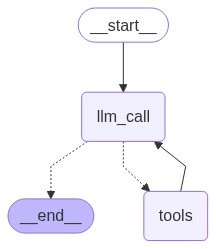

In [ ]:
rag_prompt = """
You are a helpful medical research assistant tasked with retrieving information from PubMed articles. 
Always clarify the user's research question or scope before retrieving. 
Use the retrieval tool to gather relevant PubMed abstracts, metadata, and references. 
Reflect on the retrieved context, prioritize citing references, and synthesize findings into accurate, evidence-based responses. 
If more context is needed, continue retrieving until you have sufficient coverage to answer the user's request thoroughly.
"""


class State(MessagesState):
    texts: str


def llm_call(state: State):
    messages = state.get("messages", [])

    # If no messages yet, start the conversation
    if not messages:
        messages = [
            SystemMessage(content=rag_prompt),
            HumanMessage(content=state["texts"]),
        ]

    response = llm_with_tools.invoke(messages)
    return {"messages": messages + [response]}


# state = State(texts="What are the approaches to Task Decomposition?")
graph = StateGraph(State)
graph.add_node("llm_call", llm_call)
graph.add_node("tools", ToolNode(tools))

graph.set_entry_point("llm_call")
graph.add_conditional_edges(
    "llm_call", tools_condition, {"tools": "tools", "__end__": END}
)
graph.add_edge("tools", "llm_call")

full_graph = graph.compile()
full_graph

In [ ]:
state = State(texts="What are the applications of AI in medicine according to PubMed?")
result = full_graph.invoke(state)

print(result["messages"][-1].content)  # Final assistant answer

Based on my search of PubMed literature, here's a comprehensive overview of the applications of artificial intelligence in medicine:

## Major Applications of AI in Medicine According to PubMed Research

### 1. **Medical Imaging and Diagnostics**
- **Radiology**: AI algorithms significantly improve accuracy and efficiency in interpreting X-rays, CT scans, and MRIs
- **Pathology**: Automated analysis of tissue samples and digital pathology images
- **Cardiology**: Coronary calcium scoring and early detection of cardiovascular abnormalities
- **Breast Cancer Screening**: Enhanced detection in mammography, ultrasound, and MRI
- **Ophthalmology**: Retinal image analysis for early eye disease detection
- **Nuclear Medicine**: AI-assisted image generation and interpretation

### 2. **Clinical Decision Support Systems**
- **Diagnostic Assistance**: AI tools that help physicians interpret complex medical data
- **Treatment Planning**: Personalized treatment recommendations based on patient dat